# scriptbase topic model

In [1]:
import pandas as pd
import numpy as np

friends = pd.read_csv('friends_mastersheet.csv', index_col=0)
friends.head()

Year_of_prod  Season  Episode Number  \
0          1994       1               1   
1          1994       1               2   
2          1994       1               3   
3          1994       1               4   
4          1994       1               5   

                                     Episode_Title  Duration  \
0  The One Where Monica Gets a Roommate: The Pilot        22   
1             The One with the Sonogram at the End        22   
2                           The One with the Thumb        22   
3               The One with George Stephanopoulos        22   
4   The One with the East German Laundry Detergent        22   

                                             Summary       Director  Stars  \
0  Monica and the gang introduce Rachel to the "r...  James Burrows    8.3   
1  Ross finds out his ex-wife is pregnant. Rachel...  James Burrows    8.1   
2  Monica becomes irritated when everyone likes h...  James Burrows    8.2   
3  Joey and Chandler take Ross to a hockey game t...  James Burrows    8.1   
4  Eager to spend time with Rachel, Ross pretends...  Pamela Fryman    8.5   

   Votes  match                                               text  \
0   7440     11  tell guy work going guy got wrong nice hump hu...   
1   4888     12  guys understand kissing important need know ki...   
2   4605     13  hi guys good walked subway said ouch said good...   
3   4468     14  omnipotent day want world peace hunger good th...   
4   4438     15  let big deal big deal amazing reach little man...   

   len in words  len_prep  
0        3167.0     905.0  
1        2030.0     531.0  
2        2326.0     631.0  
3        2298.0     695.0  
4        2444.0     655.0

In [2]:
np.mean(friends['len_prep'])

686.228813559322

## Some checks

In [3]:
# 5 least popular Friends episodes

check = friends.sort_values(by='Stars')

for i in range(5):
    row = check.iloc[i]
    episode = row['Episode Number']
    name = row['Episode_Title']
    season = row['Season']
    summary = row['Summary']
    stars = row['Stars']
    print(f'season {season} episode {episode} , "{name}" rating = {stars} stars: \n\n {summary}\n')

season 4 episode 21 , "The One with the Invitation" rating = 7.2 stars: 

 As Ross and Emily send out wedding invitations, he and Rachel each look back on their relationship together while Joey and Chandler look for a purpose in life.

season 6 episode 20 , "The One with Mac and C.H.E.E.S.E." rating = 7.4 stars: 

 Chandler forgets to write down a message for Joey when the time of his audition for the lead in a TV show is changed.

season 8 episode 19 , "The One with Joey's Interview" rating = 7.5 stars: 

 Joey prepares for his epic interview with Soap Opera Digest, reminiscing about his past acting experiences, his friends and his romantic life.

season 7 episode 21 , "The One with the Vows" rating = 7.5 stars: 

 Monica and Chandler are getting married in four weeks and have to write their vows, but neither has a clue what to say, so they reflect on their past.

season 9 episode 10 , "The One with Christmas in Tulsa" rating = 7.5 stars: 

 Chandler must spend Christmas in Tulsa, whi

In [4]:
# 5 most popular Friends episodes

check = friends.sort_values(by='Stars', ascending=False)

for i in range(5):
    row = check.iloc[i]
    episode = row['Episode Number']
    name = row['Episode_Title']
    season = row['Season']
    summary = row['Summary']
    stars = row['Stars']
    print(f'season {season} episode {episode} , "{name}" rating = {stars} stars: \n\n {summary}\n')

season 10 episode 18 , "The Last One: Part 2" rating = 9.7 stars: 

 Phoebe races Ross to the airport in a bid to stop Rachel from leaving for Paris. Monica and Chandler pack up their apartment ahead of their move to their new house, and Joey buys Chandler a new chick and duck as a leaving present.

season 5 episode 14 , "The One Where Everybody Finds Out" rating = 9.7 stars: 

 When Phoebe finds out about Monica and Chandler, she and Rachel attempt to get them to confess their relationship.

season 10 episode 17 , "The Last One: Part 1" rating = 9.5 stars: 

 Erica gives birth to the baby that Monica and Chandler are adopting. However, there's one small added surprise. Meanwhile, Ross and Rachel sleep together one last time before Rachel leaves ...                See full summary »

season 4 episode 12 , "The One with the Embryos" rating = 9.5 stars: 

 Phoebe's uterus is examined for implantation of the embryos. Meanwhile, a seemingly harmless game between Chandler and Joey against M

## prep

In [5]:
import glob
import random
RND = 12345
random.seed(RND)

class Chunker(object):
    def __init__(self, filenames, metadata, singles_only=False,
                 max_chars_per_book=None, chunk_size=None):
        
        # maximum number of characters to read from the beginning of each book:
        self.max_chars_per_book = max_chars_per_book
        
        # size of the chunks returned (in tokens):
        self.chunk_size = chunk_size
        
        # only return chunks from these files:
        self.filenames = filenames
        
        # include a dictionary with metadata:
        self.meta = meta
        
        # only return texts with a single genre label:
        self.singles_only = singles_only
        
        # only collect genres during the first iteration
        self.first = True

    def __iter__(self):
        if self.first:
            self.genres = []
        
        for filename in self.filenames:
            title = os.path.basename(filename[:-4])
            current_genres = self.meta[title]
            
            if self.singles_only:
                if len(current_genres) > 1:
                    continue

            with open(filename, 'r', encoding='utf-8') as f:
                try:
                    if self.max_chars_per_book:
                        text = f.read()
                        text = text[:self.max_chars_per_book]
                    else:
                        text = f.read()
                except:
                    continue
            
            tokens = text.split()
            
            for i in range(0, len(tokens), self.chunk_size):
                if self.first:
                    self.genres.append(current_genres)
                yield tokens[i:i + self.chunk_size]
                #this also helps for lazy loading because yield goes over it apart
        
        # stop collecting labels after first complete iteration
        self.first = False

In [6]:
n_features = 5000 # number of most common words
n_topics = 30 # number of topics
n_top_words = 60 # number of characteristic words per topic (viz purposes only)
max_df = 0.5 # maximum document frequency
min_df = 100 # minimum document frequency
max_books = 1000 # include all books (None), or a specific number
chunk_size = 686  # length of the average friends episode (after keeping only ADJ, NOUN & VERB)

In [7]:
path = './scriptbase/scriptbase_texts/*.txt'
filenames = sorted(list(glob.glob(path)))
print(len(filenames))

865


In [8]:
random.seed(RND)
random.shuffle(filenames)
# print(filenames[:10])
# print(len(filenames))

In [9]:
import json
with open('./scriptbase/scriptbase_meta.json', 'r') as f:
    meta = json.loads(f.read())

# for book, genres in list(meta.items())[:20]:
#     print(f"{book} -> {' - '.join(sorted(genres))}")

## NMF

In [10]:
import os
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def identity(x):
    return x

chunks = Chunker(filenames, meta,
                 chunk_size=chunk_size,
                 max_chars_per_book=None)


vectorizer = TfidfVectorizer(max_df=max_df, min_df=min_df,
                             max_features=n_features,
                             analyzer=identity)
X = vectorizer.fit_transform(chunks)

from sklearn.decomposition import NMF
nmf = NMF(n_components=300,
          random_state=RND,
          verbose=1, max_iter=100).fit(X) # fit NMF model with TF-IDF feature

import joblib
joblib.dump(nmf,'nmf_scriptbase_friends.sav')
# nmf = joblib.load('nmf_scriptbase_friends.sav')

violation: 1.0
violation: 0.026689394815118072
violation: 0.04271061762361531
violation: 0.04470177441240292
violation: 0.048787262758002964
violation: 0.04787811212987727
violation: 0.04465744550594209
violation: 0.041345923062611895
violation: 0.03936380252781542
violation: 0.03774836160062676
violation: 0.03388288629613069
violation: 0.029317592468713002
violation: 0.02554800672867217
violation: 0.021768427213153075
violation: 0.018314104504025003
violation: 0.015615927565660125
violation: 0.013329768995620366
violation: 0.011343066667077455
violation: 0.009825069102165553
violation: 0.008663346994129352
violation: 0.007844896587588324
violation: 0.007227572210552008
violation: 0.006652057347537876
violation: 0.006116861055960377
violation: 0.005702896579873386
violation: 0.005435936501979561
violation: 0.00527895792311416
violation: 0.005033667109267604
violation: 0.00464453211659706
violation: 0.00425596661355313
violation: 0.00396720273948898
violation: 0.0037330389147043476
viol

c:\Users\Gebruiker\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  warnings.warn(


['nmf_scriptbase_friends.sav']

In [11]:
for topic_idx, topic in enumerate(nmf.components_[:10]):
    top_idxs = np.argsort(topic)[::-1][:10]
    top_words = np.array(vectorizer.get_feature_names())[top_idxs]
    print(f'topic {topic_idx}:', ' - '.join(top_words))

topic 0: knew - saw - went - loved - died - took - looked - felt - called - gave
topic 1: fuck - fucked - motherfucker - asshole - bitch - fucker - dick - bullshit - fuckin - fucks
topic 2: nuclear - weapons - russian - intelligence - military - american - attack - report - strike - political
topic 3: ai - talkin - comin - gettin - tryin - folks - mama - askin - seen - damn
topic 4: son - bitch - loves - sons - today - department - easy - swear - favor - fault
topic 5: ship - crew - space - mission - event - bridge - main - command - systems - prepare
topic 6: looks - turns - pulls - sees - nods - sits - walks - opens - takes - stares
topic 7: dad - parents - junior - proud - making - bike - swear - pass - tried - nuts
topic 8: players - field - pitch - smiles - strike - fans - nods - beat - toast - stares
topic 9: money - cash - pay - grand - vegas - paid - bills - bucks - rich - wants


c:\Users\Gebruiker\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [12]:
nmf.verbose = 1
X_ = nmf.transform(X)
print(X_.shape)

violation: 1.0
violation: 0.19515034261449565
violation: 0.04086806522054348
violation: 0.010722161918713377
violation: 0.00209193328993231
violation: 0.0007346761763469093
violation: 0.00014395115204247084
violation: 5.5535829877266146e-05
Converged at iteration 9
(4263, 300)


In [13]:
from sklearn.feature_selection import f_classif

genres = [g[0] for g in chunks.genres]
feature_names = vectorizer.get_feature_names()

for genre in set(genres):
    print(f'-> genre {genre}:')
    y = [1 if g == genre else 0 for g in genres]
    # univariate feature selection with F-test for feature scoring
    F, pval = f_classif(X_, y)
    
    # indices of three best topics
    for topic_idx in np.argsort(F)[::-1][:3]:
        topic = np.nan_to_num(nmf.components_[topic_idx])
        words = [feature_names[i] for i in topic.argsort()[:-10:-1]]
        print('   ' + f't{topic_idx}' + ' - '.join(words))

c:\Users\Gebruiker\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


-> genre thriller:
   murder - evidence - murderer - murdered - crime - guilty - murders - found - prove
   source - cell - signal - target - location - message - threat - subject - weapon
   detective - partner - suspect - investigation - homicide - found - questions - laws - saw
-> genre comedy:
   date - dating - boyfriend - weird - cute - girlfriend - wear - likes - kidding
   guys - balls - weird - couple - screw - assholes - second - gets - dick
   fun - funny - having - jokes - nervous - laugh - joke - thinking - makes
-> genre crime:
   cops - dope - jail - package - rat - mob - street - warrant - knows
   money - cash - pay - grand - vegas - paid - bills - bucks - rich
   business - deal - meeting - meet - personal - heard - interested - sign - offer
-> genre adventure:
   data - brand - mouth - map - tunnel - rich - bathroom - restaurant - houses
   power - use - powers - bound - system - destroy - reach - create - dark
   earth - plant - space - e - read - face - snow - peac

In [14]:
import pandas as pd
nmf.verbose = 0

texts = [value.split() for value in friends.text.values]

scores = nmf.transform(vectorizer.transform(texts))  # transform the HP chapters according to the fitted NMF model
scores.shape
# print(scores)

(236, 300)

In [15]:
df_scores = pd.DataFrame(scores, columns=[f't{i+1}' for i in range(scores.shape[1])])
friends2 = friends.join(df_scores)
friends2.head()

Year_of_prod  Season  Episode Number  \
0          1994       1               1   
1          1994       1               2   
2          1994       1               3   
3          1994       1               4   
4          1994       1               5   

                                     Episode_Title  Duration  \
0  The One Where Monica Gets a Roommate: The Pilot        22   
1             The One with the Sonogram at the End        22   
2                           The One with the Thumb        22   
3               The One with George Stephanopoulos        22   
4   The One with the East German Laundry Detergent        22   

                                             Summary       Director  Stars  \
0  Monica and the gang introduce Rachel to the "r...  James Burrows    8.3   
1  Ross finds out his ex-wife is pregnant. Rachel...  James Burrows    8.1   
2  Monica becomes irritated when everyone likes h...  James Burrows    8.2   
3  Joey and Chandler take Ross to a hockey game t...  James Burrows    8.1   
4  Eager to spend time with Rachel, Ross pretends...  Pamela Fryman    8.5   

   Votes  match  ...      t291      t292      t293      t294      t295  \
0   7440     11  ...  0.000000  0.036589  0.003537  0.000000  0.000000   
1   4888     12  ...  0.000000  0.018084  0.000000  0.013036  0.000000   
2   4605     13  ...  0.000901  0.018507  0.000000  0.000000  0.003711   
3   4468     14  ...  0.001811  0.036734  0.004993  0.000000  0.000000   
4   4438     15  ...  0.000000  0.036067  0.009392  0.001201  0.006378   

       t296      t297     t298  t299      t300  
0  0.016953  0.000000  0.00000   0.0  0.000000  
1  0.000633  0.002123  0.00000   0.0  0.001601  
2  0.000000  0.000000  0.00000   0.0  0.000000  
3  0.000000  0.000000  0.00000   0.0  0.000174  
4  0.004056  0.000000  0.00073   0.0  0.000000  

[5 rows x 313 columns]

In [16]:
from operator import itemgetter
from scipy.stats import kendalltau

ranks = range(1, len(friends2.index)+1)
tau_scores = []
for col in [f't{i+1}' for i in range(scores.shape[1])]:
    tau, p = kendalltau(ranks, friends2[col].tolist())
    tau_scores.append((col, tau))
    
tau_scores.sort(key=itemgetter(1))
nb = 6
top, bottom = tau_scores[:nb], tau_scores[-nb:]
print(tau_scores[:10]) # print 10 topics with lowest Tau score

[('t73', -0.167757468956831), ('t264', -0.1608451380876532), ('t149', -0.15980171434179335), ('t171', -0.15058535768290823), ('t296', -0.14224731734228574), ('t262', -0.13386252497225362), ('t146', -0.12919156882550892), ('t258', -0.12308846835086237), ('t207', -0.1182035718854015), ('t276', -0.11579501528286255)]


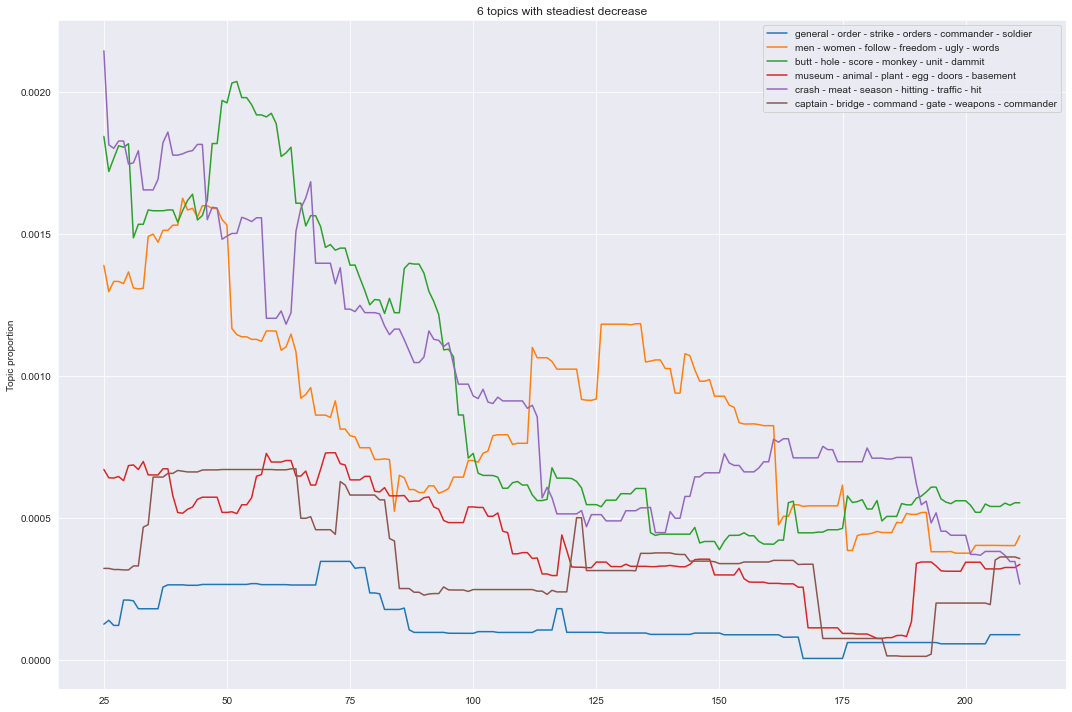

In [17]:
import matplotlib.pyplot as plt

import seaborn as sb
feature_names = vectorizer.get_feature_names_out()
fig = plt.figure(figsize=(15, 10))
sb.set_style("darkgrid")
for (feat, tau), col in zip(top, sb.color_palette("Set1")[:nb]):
    topic = nmf.components_[int(feat.replace('t', '')) - 1, :]
    words = [feature_names[i] for i in topic.argsort()[:-6-1:-1]]
    label = ' - '.join(words)
    friends2[feat].rolling(window=50, center=True).mean().plot(label=label)
plt.xlabel('', fontsize=10)
plt.ylabel('Topic proportion', fontsize=10)
plt.title(f'{nb} topics with steadiest decrease')
plt.tight_layout()
plt.legend();

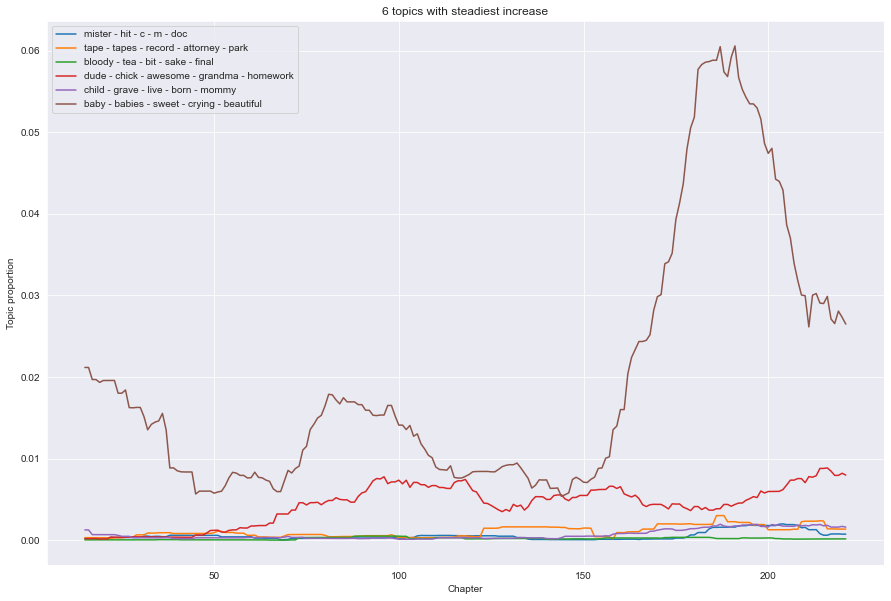

In [18]:
fig = plt.figure(figsize=(15, 10))
sb.set_style("darkgrid")
for (feat, tau), col in zip(bottom, sb.color_palette("Set1")[:nb]):
    topic = nmf.components_[int(feat.replace('t', '')) - 1, :]
    words = [feature_names[i] for i in topic.argsort()[:-5-1:-1]]
    label = ' - '.join(words)
    friends2[feat].rolling(window=30, center=True).mean().plot(label=label)
plt.xlabel('Chapter', fontsize=10)
plt.ylabel('Topic proportion', fontsize=10)
plt.title(f'{nb} topics with steadiest increase')
plt.legend();

In [19]:
#25 most predictive topics

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

feature_names = vectorizer.get_feature_names_out()
X = friends2.drop(columns=friends.columns.tolist())


y = friends2.Stars
# univariate feature selection with F-test for feature scoring
F, pval = f_regression(X, y)
    
    
for topic_idx in np.argsort(F)[::-1][:25]:
    topic = np.nan_to_num(nmf.components_[topic_idx])
    words = [feature_names[i] for i in topic.argsort()[:-10:-1]]
    print(f't{topic_idx}: ' + ' - '.join(words))

t26: plane - flight - pilot - fly - flying - airport - landing - flew - trip
t233: summer - girlfriend - sensitive - beach - loved - throw - crap - favorite - garage
t276: job - working - fired - quit - months - pay - easy - jobs - week
t12: minutes - seconds - hours - ready - hold - hour - moving - second - close
t204: forget - realize - legal - available - gets - comes - watch - matter - drop
t287: dear - tea - suppose - sort - wish - hand - poor - present - excuse
t191: prison - sentence - jail - crime - guards - terrific - cell - escape - free
t132: write - writer - writing - read - wrote - script - paper - page - written
t239: stock - buy - firm - sell - market - selling - month - buying - sale
t288: cops - dope - jail - package - rat - mob - street - warrant - knows
t32: news - network - television - week - division - air - share - mad - middle
t205: business - deal - meeting - meet - personal - heard - interested - sign - offer
t299: rock - band - roll - magazine - stone - rolli

### Predictions 
#### setting baselines

In [20]:
import numpy as np
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_score, LeaveOneOut
from sklearn.model_selection import train_test_split

X = friends2.drop(columns=friends.columns.tolist())
y = friends2.Stars

cv = LeaveOneOut()

dummy_regr = DummyRegressor(strategy="mean")

scores = cross_val_score(dummy_regr, X, y, cv=cv, scoring = 'neg_root_mean_squared_error')

print(np.mean(scores), np.std(scores))


-0.3113667508113955 0.24655333378118335


In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

X = friends['text']
y = friends2.Stars

cv = LeaveOneOut()

reg = LinearRegression()
vect = TfidfVectorizer()

pipe = make_pipeline(vect, reg)

scores = cross_val_score(pipe, X, y, cv=cv, scoring = 'neg_root_mean_squared_error')

print(np.mean(scores), np.std(scores))


-0.31851935143924304 0.27816024426521413


In [24]:
friends.columns

Index(['Year_of_prod', 'Season', 'Episode Number', 'Episode_Title', 'Duration',
       'Summary', 'Director', 'Stars', 'Votes', 'match', 'text',
       'len in words', 'len_prep'],
      dtype='object')

#### predictions with topics

In [25]:
#all features
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

feature_names = vectorizer.get_feature_names_out()
X = friends2.drop(columns=friends.columns.tolist())
y = friends2.Stars

reg = LinearRegression()

scores = cross_val_score(reg, X, y, cv=cv, scoring = 'neg_root_mean_squared_error')

print(np.mean(scores), np.std(scores))

-282572583661.7789 478205873753.5635


In [26]:
#25 best features
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

Best = [f't{topic_idx}' for topic_idx in np.argsort(F)[::-1][:25]]

feature_names = vectorizer.get_feature_names_out()
X = friends2[Best]
y = friends2.Stars

reg = LinearRegression()
scal = StandardScaler()

pipe = make_pipeline(reg, scal)

scores = cross_val_score(reg, X, y, cv=cv, scoring = 'neg_root_mean_squared_error')

print(np.mean(scores), np.std(scores))

-0.33367966747160266 0.24992961968435046


In [27]:
#10 best features
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

Best = [f't{topic_idx}' for topic_idx in np.argsort(F)[::-1][:10]]

feature_names = vectorizer.get_feature_names_out()
Xble = friends2.drop(columns=friends.columns.tolist())
X = Xble[Best]
y = friends2.Stars

reg = LinearRegression()
scal = StandardScaler()

pipe = make_pipeline(reg, scal)

scores = cross_val_score(reg, X, y, cv=cv, scoring = 'neg_root_mean_squared_error')

print(np.mean(scores), np.std(scores))

-0.32149647776161216 0.24107787441249537


In [28]:
Best = [f't{topic_idx}' for topic_idx in np.argsort(F)[::-1][:10]]
xtra = ['Year_of_prod', 'Votes', 'Duration']

cols = Best+xtra

cols.append('Stars')

scal = StandardScaler()

corrM = friends2[cols].corr()
 
corrM


t26      t233      t276       t12      t204      t287  \
t26           1.000000 -0.050529 -0.041656  0.064534  0.015167  0.315867   
t233         -0.050529  1.000000  0.042395  0.035233  0.058941 -0.022387   
t276         -0.041656  0.042395  1.000000 -0.015652  0.184594 -0.031688   
t12           0.064534  0.035233 -0.015652  1.000000 -0.123305  0.021525   
t204          0.015167  0.058941  0.184594 -0.123305  1.000000  0.013661   
t287          0.315867 -0.022387 -0.031688  0.021525  0.013661  1.000000   
t191          0.020317  0.015390 -0.030752 -0.062135 -0.030023 -0.034414   
t132         -0.080459 -0.062362 -0.044273 -0.079453  0.005684 -0.047213   
t239         -0.055941  0.080481 -0.012114 -0.004885  0.132949  0.184081   
t288          0.013590 -0.123872 -0.006903 -0.019783 -0.021811 -0.050549   
Year_of_prod  0.162739 -0.108796 -0.003102  0.019929 -0.010257  0.097192   
Votes         0.015684  0.084715 -0.050277  0.135382 -0.005757  0.061631   
Duration      0.009467  0.050559 -0.035853 -0.022808  0.014453  0.089821   
Stars         0.049440  0.063881 -0.047293  0.106291 -0.069960  0.007175   

                  t191      t132      t239      t288  Year_of_prod     Votes  \
t26           0.020317 -0.080459 -0.055941  0.013590      0.162739  0.015684   
t233          0.015390 -0.062362  0.080481 -0.123872     -0.108796  0.084715   
t276         -0.030752 -0.044273 -0.012114 -0.006903     -0.003102 -0.050277   
t12          -0.062135 -0.079453 -0.004885 -0.019783      0.019929  0.135382   
t204         -0.030023  0.005684  0.132949 -0.021811     -0.010257 -0.005757   
t287         -0.034414 -0.047213  0.184081 -0.050549      0.097192  0.061631   
t191          1.000000 -0.037796 -0.061385 -0.019567     -0.149274  0.081557   
t132         -0.037796  1.000000  0.091053 -0.069041      0.173193 -0.067834   
t239         -0.061385  0.091053  1.000000 -0.046003     -0.099413  0.085038   
t288         -0.019567 -0.069041 -0.046003  1.000000      0.178351 -0.098502   
Year_of_prod -0.149274  0.173193 -0.099413  0.178351      1.000000 -0.364429   
Votes         0.081557 -0.067834  0.085038 -0.098502     -0.364429  1.000000   
Duration     -0.056537  0.014515 -0.055574  0.082625      0.161111  0.238580   
Stars        -0.103613  0.025385  0.062753 -0.160075      0.071470  0.522019   

              Duration     Stars  
t26           0.009467  0.049440  
t233          0.050559  0.063881  
t276         -0.035853 -0.047293  
t12          -0.022808  0.106291  
t204          0.014453 -0.069960  
t287          0.089821  0.007175  
t191         -0.056537 -0.103613  
t132          0.014515  0.025385  
t239         -0.055574  0.062753  
t288          0.082625 -0.160075  
Year_of_prod  0.161111  0.071470  
Votes         0.238580  0.522019  
Duration      1.000000  0.237446  
Stars         0.237446  1.000000

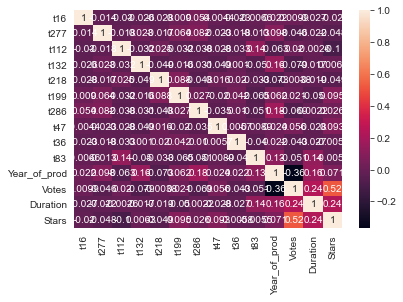

In [38]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

sn.heatmap(corrM, annot=True)
plt.show()

In [39]:
# print(friends2.Director.value_counts())

lst = ['Gary Halvorson',        
'Kevin Bright',          
'Michael Lembeck',       
'James Burrows',           
'Gail Mancuso',           
'Peter Bonerz',            
'David Schwimmer',         
'Ben Weiss']

def direr(wow):
    if wow not in lst:
        wow = wow.replace(wow,'Other')
    return wow

friends2['Director'] = friends2['Director'].apply(direr)

print(friends2.Director.value_counts())

Gary Halvorson     54
Kevin Bright       54
Other              43
Michael Lembeck    24
James Burrows      15
Gail Mancuso       14
Peter Bonerz       12
David Schwimmer    10
Ben Weiss          10
Name: Director, dtype: int64


In [52]:
Best = [f't{topic_idx}' for topic_idx in np.argsort(F)[1::-1]]
xtra = ['Year_of_prod', 'Duration', 'Director']

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

cols = Best+xtra

X = friends2[cols]
y = friends2.Stars

reg = LinearRegression()
hot = OneHotEncoder()
scal = StandardScaler()

categorical_features = X.select_dtypes(include="object").columns
integer_features = X.select_dtypes(exclude="object").columns

prep = make_column_transformer((hot, categorical_features),
                                (scal, integer_features))

pipe = make_pipeline(prep,reg)

scores = cross_val_score(pipe, X, y, cv=cv, scoring = 'neg_root_mean_squared_error')

print(np.mean(scores), np.std(scores))

-0.30414062232751493 0.24315648926089023


In [41]:
Best = [f't{topic_idx}' for topic_idx in np.argsort(F)[::-1][:25]]
xtra = ['Year_of_prod', 'Duration', 'Director']

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

cols = Best+xtra

X = friends2[cols]
y = friends2.Stars

reg = LinearRegression()
hot = OneHotEncoder()
scal = StandardScaler()

categorical_features = X.select_dtypes(include="object").columns
integer_features = X.select_dtypes(exclude="object").columns

prep = make_column_transformer((hot, categorical_features),
                                (scal, integer_features))

pipe = make_pipeline(prep,reg)

scores = cross_val_score(pipe, X, y, cv=10, scoring = 'neg_root_mean_squared_error')

print(np.mean(scores), np.std(scores))

-0.4601473462865432 0.059412119625408294


In [42]:
Best = [f't{topic_idx}' for topic_idx in np.argsort(F)[::-1][:10]]
xtra = ['Year_of_prod', 'Duration', 'Director']

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

cols = Best+xtra

X = friends2[cols]
y = friends2.Stars

reg = LinearRegression()
hot = OneHotEncoder()
scal = StandardScaler()

categorical_features = X.select_dtypes(include="object").columns
integer_features = X.select_dtypes(exclude="object").columns

prep = make_column_transformer((hot, categorical_features),
                                (scal, integer_features))

pipe = make_pipeline(prep,reg)

scores = cross_val_score(pipe, X, y, cv=10, scoring = 'neg_root_mean_squared_error')

print(np.mean(scores), np.std(scores))

-0.42238689134705404 0.04159380506501158


In [31]:
# import joblib
# filename = 'nmf_books_friends.sav'
# joblib.dump(nmf, filename)

['nmf_books_friends.sav']

### SVR

In [43]:
from sklearn.svm import SVR

feature_names = vectorizer.get_feature_names_out()
X = friends2.drop(columns=friends.columns.tolist())
y = friends2.Stars

reg = SVR()
scal = StandardScaler()

pipe = make_pipeline(reg, scal)

scores = cross_val_score(reg, X, y, cv=10, scoring = 'neg_root_mean_squared_error')

print(np.mean(scores), np.std(scores))

-0.4209709651377519 0.04900406499839548


In [51]:
from sklearn.svm import SVR

Best = [f't{topic_idx}' for topic_idx in np.argsort(F)[::-1][:25]]

feature_names = vectorizer.get_feature_names_out()
X = friends2[Best]
y = friends2.Stars

reg = SVR()
scal = StandardScaler()

pipe = make_pipeline(reg, scal)

scores = cross_val_score(reg, X, y, cv=10, scoring = 'neg_root_mean_squared_error')

print(np.mean(scores), np.std(scores))

-0.4269642548856371 0.06804596026969317


In [78]:
Best = [f't{topic_idx}' for topic_idx in np.argsort(F)[::-1][:10]]

feature_names = vectorizer.get_feature_names_out()
X = friends2[Best]
y = friends2.Stars

reg = SVR()
scal = StandardScaler()

pipe = make_pipeline(reg, scal)

scores = cross_val_score(reg, X, y, cv=10, scoring = 'neg_root_mean_squared_error')

print(np.mean(scores), np.std(scores))

-0.41355260347536077 0.054011321600815024


In [79]:
Best = [f't{topic_idx}' for topic_idx in np.argsort(F)[1::-1]]
xtra = ['Year_of_prod', 'Duration', 'Director']

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

cols = Best+xtra

X = friends2[cols]
y = friends2.Stars

reg = SVR()
hot = OneHotEncoder()
scal = StandardScaler()

categorical_features = X.select_dtypes(include="object").columns
integer_features = X.select_dtypes(exclude="object").columns

prep = make_column_transformer((hot, categorical_features),
                                (scal, integer_features))

pipe = make_pipeline(prep,reg)

scores = cross_val_score(pipe, X, y, cv=10, scoring = 'neg_root_mean_squared_error')

print(np.mean(scores), np.std(scores))

-0.4229000071383643 0.06739912152089038


In [80]:
Best = [f't{topic_idx}' for topic_idx in np.argsort(F)[::-1][:25]]
xtra = ['Year_of_prod', 'Duration', 'Director']

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

cols = Best+xtra

X = friends2[cols]
y = friends2.Stars

reg = SVR()
hot = OneHotEncoder()
scal = StandardScaler()

categorical_features = X.select_dtypes(include="object").columns
integer_features = X.select_dtypes(exclude="object").columns

prep = make_column_transformer((hot, categorical_features),
                                (scal, integer_features))

pipe = make_pipeline(prep,reg)

scores = cross_val_score(pipe, X, y, cv=10, scoring = 'neg_root_mean_squared_error')

print(np.mean(scores), np.std(scores))

-0.4256167722242978 0.053832344041550656


In [81]:
Best = [f't{topic_idx}' for topic_idx in np.argsort(F)[::-1][:10]]
xtra = ['Year_of_prod', 'Duration', 'Director']

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

cols = Best+xtra

X = friends2[cols]
y = friends2.Stars

reg = SVR()
hot = OneHotEncoder()
scal = StandardScaler()

categorical_features = X.select_dtypes(include="object").columns
integer_features = X.select_dtypes(exclude="object").columns

prep = make_column_transformer((hot, categorical_features),
                                (scal, integer_features))

pipe = make_pipeline(prep,reg)

scores = cross_val_score(pipe, X, y, cv=10, scoring = 'neg_root_mean_squared_error')

print(np.mean(scores), np.std(scores))

-0.4243136464831898 0.051222479025645556


### gradient boosting

In [71]:
from sklearn.ensemble import GradientBoostingRegressor

feature_names = vectorizer.get_feature_names_out()
X = friends2.drop(columns=friends.columns.tolist())
y = friends2.Stars

reg = GradientBoostingRegressor()
scal = StandardScaler()

pipe = make_pipeline(reg, scal)

scores = cross_val_score(reg, X, y, cv=10, scoring = 'neg_root_mean_squared_error')

print(np.mean(scores), np.std(scores))

-0.4243307529303612 0.05454752391623509


In [72]:
Best = [f't{topic_idx}' for topic_idx in np.argsort(F)[::-1][:25]]

feature_names = vectorizer.get_feature_names_out()
X = friends2[Best]
y = friends2.Stars

reg = GradientBoostingRegressor()
scal = StandardScaler()

pipe = make_pipeline(reg, scal)

scores = cross_val_score(reg, X, y, cv=10, scoring = 'neg_root_mean_squared_error')

print(np.mean(scores), np.std(scores))

-0.4743865021548091 0.05309363102278743


In [73]:
Best = [f't{topic_idx}' for topic_idx in np.argsort(F)[::-1][:10]]

feature_names = vectorizer.get_feature_names_out()
X = friends2[Best]
y = friends2.Stars

reg = GradientBoostingRegressor()
scal = StandardScaler()

pipe = make_pipeline(reg, scal)

scores = cross_val_score(reg, X, y, cv=10, scoring = 'neg_root_mean_squared_error')

print(np.mean(scores), np.std(scores))

-0.4626873499655191 0.05295926483927544


In [82]:
Best = [f't{topic_idx}' for topic_idx in np.argsort(F)[1::-1]]
xtra = ['Year_of_prod', 'Duration', 'Director']

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

cols = Best+xtra

X = friends2[cols]
y = friends2.Stars

reg = GradientBoostingRegressor()
hot = OneHotEncoder()
scal = StandardScaler()

categorical_features = X.select_dtypes(include="object").columns
integer_features = X.select_dtypes(exclude="object").columns

prep = make_column_transformer((hot, categorical_features),
                                (scal, integer_features))

pipe = make_pipeline(prep,reg)

scores = cross_val_score(pipe, X, y, cv=10, scoring = 'neg_root_mean_squared_error')

print(np.mean(scores), np.std(scores))

-0.4519760133963449 0.09862278303568002


In [76]:
Best = [f't{topic_idx}' for topic_idx in np.argsort(F)[::-1][:25]]
xtra = ['Year_of_prod', 'Duration', 'Director']

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

cols = Best+xtra

X = friends2[cols]
y = friends2.Stars

reg = GradientBoostingRegressor()
hot = OneHotEncoder()
scal = StandardScaler()

categorical_features = X.select_dtypes(include="object").columns
integer_features = X.select_dtypes(exclude="object").columns

prep = make_column_transformer((hot, categorical_features),
                                (scal, integer_features))

pipe = make_pipeline(prep,reg)

scores = cross_val_score(pipe, X, y, cv=10, scoring = 'neg_root_mean_squared_error')

print(np.mean(scores), np.std(scores))

-0.4645101793031987 0.05817339521301511


In [77]:
Best = [f't{topic_idx}' for topic_idx in np.argsort(F)[::-1][:10]]
xtra = ['Year_of_prod', 'Duration', 'Director']

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

cols = Best+xtra

X = friends2[cols]
y = friends2.Stars

reg = GradientBoostingRegressor()
hot = OneHotEncoder()
scal = StandardScaler()

categorical_features = X.select_dtypes(include="object").columns
integer_features = X.select_dtypes(exclude="object").columns

prep = make_column_transformer((hot, categorical_features),
                                (scal, integer_features))

pipe = make_pipeline(prep,reg)

scores = cross_val_score(pipe, X, y, cv=10, scoring = 'neg_root_mean_squared_error')

print(np.mean(scores), np.std(scores))

-0.42918556542695996 0.06242421122639609
